# ClonalOrigin model and simulation-based inference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sbi.utils.torchutils import BoxUniform
from sbi.inference import NPE_C, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import sys
sys.path.append('../pysimARG')
from clonal_genealogy import ClonalTree
from ClonalOrigin_simulator import ClonalOrigin_simulator

torch_device = "cpu"

c:\Users\u2008181\likelihood-free\sbi_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\u2008181\likelihood-free\sbi_env\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## Observation data, simulator and prior

**Simulate observed data**

Set the true parameters as
* $\rho_s = 0.02$,
* $\delta = 300$,
* $\theta_s = 0.05$.

In [2]:
np.random.seed(100)
tree = ClonalTree(n=10)

In [3]:
rho_site = 0.02
theta_site = 0.05
L = 100000
delta = 300

x_o = ClonalOrigin_simulator(tree, rho_site, theta_site, L, delta, N=2000, k_vec=[50, 200, 2000])
x_o = torch.tensor(x_o, device=torch_device)
x_o = x_o.flatten()

x_o_numpy = x_o.cpu().numpy()

In [4]:
x_o

tensor([0.0046, 0.0048, 0.0024, 0.0000, 0.0020, 0.0015, 0.1452],
       dtype=torch.float64)

**Define prior distribution**

We set the prior to be uniform with range:
* $[0, 0.2]$ for $\rho_s$,
* $[1, 500]$ for $\delta$,
* $[0, 0.2]$ for $\theta_s$.

In [5]:
prior = BoxUniform(
    low=torch.tensor([0.0, 1.0, 0.0], device=torch_device),
    high=torch.tensor([0.2, 500.0, 0.2], device=torch_device), 
    device=torch_device
)

**Set the simulator with tensor output**

In [11]:
def simulator(theta):
    theta = theta.reshape(-1)
    summary_stats = ClonalOrigin_simulator(tree,
                                           theta[0].item(),
                                           theta[2].item(),
                                           L,
                                           theta[1].item(),
                                           N=100, k_vec=[50, 200, 2000])
    summary_stats = torch.tensor(summary_stats, device=torch_device)
    return summary_stats

In [12]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)

In [13]:
check_sbi_inputs(simulator, prior)

## NPE-C

In [14]:
simulation_budget = 5000
seed = 100
num_posterior_samples=1000
learning_rate = 0.0005

inference = NPE_C(prior=prior, density_estimator="nsf", device=torch_device)
torch.manual_seed(seed)
np.random.seed(seed)

In [15]:
theta, x = simulate_for_sbi(
    simulator=simulator, proposal=prior, num_simulations=simulation_budget, num_workers=10
)

100%|██████████| 5000/5000 [47:03<00:00,  1.77it/s]  


In [16]:
density_estimator = inference.append_simulations(theta, x).train(
    max_num_epochs=100, learning_rate=learning_rate
)
posterior = inference.build_posterior(density_estimator).set_default_x(x_o)

 Neural network successfully converged after 76 epochs.

In [19]:
theta_trained = posterior.sample((num_posterior_samples,), x=x_o)

1082it [00:00, 35664.50it/s]            


In [21]:
theta_trained_numpy = theta_trained.cpu().numpy()

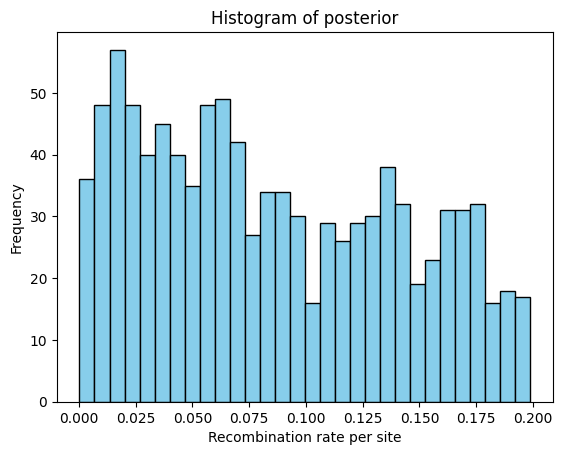

In [27]:
plt.hist(theta_trained_numpy[:, 0], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Recombination rate per site')
plt.ylabel('Frequency')
plt.title('Histogram of posterior')
plt.show()

In [30]:
theta_numpy = theta.cpu().numpy()
x_numpy = x.cpu().numpy()

In [31]:
x_numpy.shape, theta_numpy.shape

((5000, 7), (5000, 3))

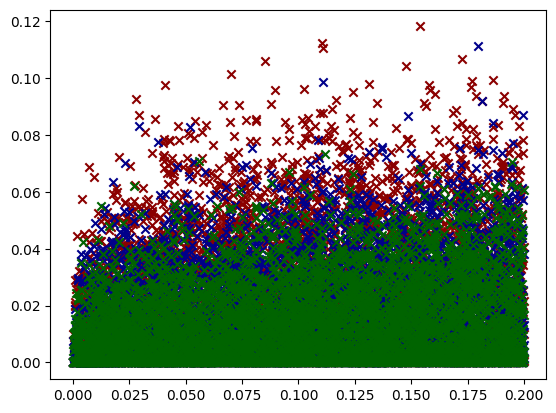

In [36]:
plt.scatter(theta_numpy[:, 0], x_numpy[:, 0], marker='x', color='darkred')
plt.scatter(theta_numpy[:, 0], x_numpy[:, 1], marker='x', color='darkblue')
plt.scatter(theta_numpy[:, 0], x_numpy[:, 2], marker='x', color='darkgreen')

# Display the plot
plt.show()

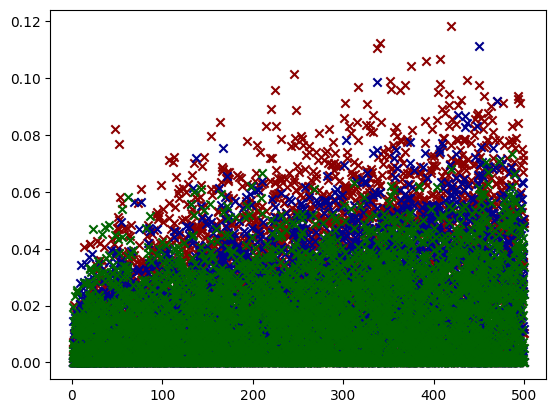

In [33]:
plt.scatter(theta_numpy[:, 1], x_numpy[:, 0], marker='x', color='darkred')
plt.scatter(theta_numpy[:, 1], x_numpy[:, 1], marker='x', color='darkblue')
plt.scatter(theta_numpy[:, 1], x_numpy[:, 2], marker='x', color='darkgreen')

# Display the plot
plt.show()

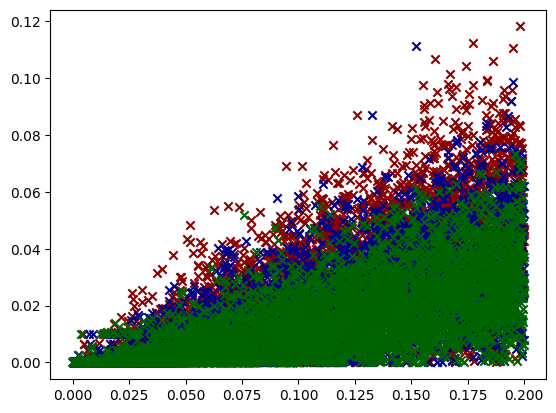

In [34]:
plt.scatter(theta_numpy[:, 2], x_numpy[:, 0], marker='x', color='darkred')
plt.scatter(theta_numpy[:, 2], x_numpy[:, 1], marker='x', color='darkblue')
plt.scatter(theta_numpy[:, 2], x_numpy[:, 2], marker='x', color='darkgreen')

# Display the plot
plt.show()